<div style="float:left">
    <h1 style="width:450px">Practical 10: Grouping Data</h1>
    <h2 style="width:450px">Classification &amp; Clusters</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

<div class="alert alert-block alert-info">
    <b>&#128279; Connections</b>: 
</div>

#### Preamble

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import math
import re
import os
import pickle as pk

from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Load GeoData for Display

In [2]:
# Load Water GeoPackage
w_path = os.path.join('data','geo','Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Water.gpkg?raw=true')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('data','geo','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

#### Useful Functions for Plotting

In [3]:
def plt_ldn(w=water, b=boroughs):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

## Loading Data

#### Load the Listings Data

Feel free to download this manually and load it locally rather that loading via the URL:

In [4]:
vsize=100

In [5]:
we = pd.read_csv(os.path.join('data','clean',f'2020-08-24-listing-description-w2v-{vsize}.csv.gz'), compression='gzip', low_memory=False)

In [6]:
print(f"Data frame is {we.shape[0]:,} x {we.shape[1]}")
we.head(3)

Data frame is 74,184 x 101


,id,WordVec 1,WordVec 2,WordVec 3,WordVec 4,WordVec 5,WordVec 6,WordVec 7,WordVec 8,WordVec 9,...,WordVec 91,WordVec 92,WordVec 93,WordVec 94,WordVec 95,WordVec 96,WordVec 97,WordVec 98,WordVec 99,WordVec 100
0,11551,0.01,0.07,-0.08,0.21,-0.10,-0.04,-0.07,0.09,-0.23,...,-0.13,-0.00,-0.07,0.01,0.13,-0.02,-0.08,0.00,0.11,-0.07
1,13913,0.01,0.10,-0.16,0.03,-0.04,0.06,-0.14,-0.08,-0.14,...,-0.06,0.08,-0.17,-0.03,0.12,-0.03,-0.10,0.01,0.11,-0.06
2,15400,0.12,0.14,-0.12,0.15,-0.09,0.06,-0.03,0.03,-0.07,...,-0.03,0.06,-0.11,-0.06,0.23,0.11,-0.05,-0.06,0.07,-0.06


You should have: `Data frame is 74,184 x 101`.

#### Link Back to Listings

In [7]:
df = pd.read_csv(os.path.join('data','raw','2020-08-24-listings.csv.gz'), compression='gzip',
                low_memory=False, usecols=['id','longitude','latitude','room_type','price'])
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

In [8]:
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
df['id'] = df.id.astype(int)
df = df[df.room_type=='Entire home/apt']
print(df.shape)

(40853, 5)


In [9]:
df.set_index('id')
wedf = pd.merge(df, we, on='id')
gdf = gpd.GeoDataFrame(wedf, 
      geometry=gpd.points_from_xy(wedf['longitude'], wedf['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700').drop(columns=['longitude','latitude','room_type']).set_index('id')
print(gdf.shape)

(40853, 102)


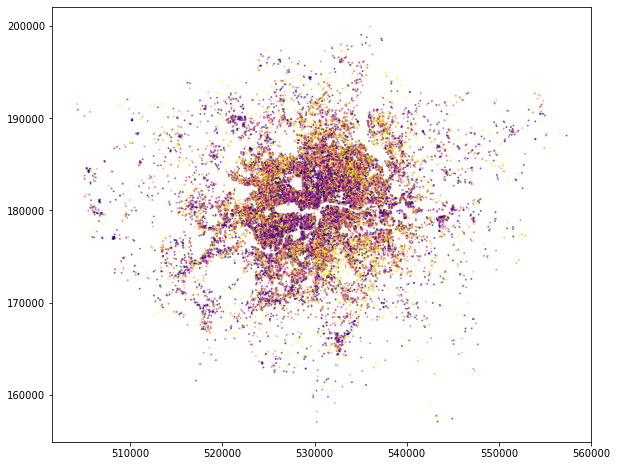

In [11]:
gdf.plot(column='WordVec 1', scheme='quantiles', k=5, 
         cmap='plasma', figsize=(10,8), markersize=1, alpha=0.5);

#### Aggregating Listings by MSOA

Next, let's link all this using the MSOA Geography that we created last week and a mix or merge and sjoin!

In [12]:
msoas = gpd.read_file(os.path.join('data','geo','London_MSOAs.gpkg'), driver='GPKG')

In [13]:
# ml == MSOA Listings
ml = gpd.sjoin(gdf, msoas[['MSOA11CD','geometry']], op='within').drop(columns=
    ['index_right','geometry']
)
ml.head()

,price,WordVec 1,WordVec 2,WordVec 3,WordVec 4,WordVec 5,WordVec 6,WordVec 7,WordVec 8,WordVec 9,...,WordVec 92,WordVec 93,WordVec 94,WordVec 95,WordVec 96,WordVec 97,WordVec 98,WordVec 99,WordVec 100,MSOA11CD
id,,,,,,,,,,,,,,,,,,,,,
11551,87.00,0.01,0.07,-0.08,0.21,-0.10,-0.04,-0.07,0.09,-0.23,...,-0.00,-0.07,0.01,0.13,-0.02,-0.08,0.00,0.11,-0.07,E02000633
1194557,110.00,0.11,-0.01,-0.13,0.18,-0.16,-0.04,0.00,0.01,-0.12,...,-0.03,-0.09,-0.09,0.09,0.05,-0.17,0.12,0.21,-0.19,E02000633
1590818,104.00,-0.06,-0.04,-0.11,0.15,-0.04,0.00,-0.01,-0.07,-0.03,...,0.03,-0.09,-0.05,0.12,-0.10,-0.01,0.15,0.12,-0.17,E02000633
1630792,95.00,0.08,-0.10,-0.11,0.16,-0.08,0.04,-0.02,-0.02,-0.20,...,0.01,-0.06,-0.02,0.08,-0.01,-0.02,-0.02,0.09,-0.16,E02000633
1913181,150.00,0.10,0.03,-0.16,0.12,-0.11,0.05,-0.05,-0.01,-0.25,...,-0.01,-0.24,0.02,0.18,0.01,-0.13,0.06,0.18,-0.16,E02000633


In [50]:
pcts = [0.15, 0.85]
price_range = ml[['MSOA11CD','price']].groupby('MSOA11CD').describe(percentiles=pcts).reset_index().set_index('MSOA11CD')
price_range.columns = price_range.columns.get_level_values(1)
price_range = price_range[[f"{x*100:0.0f}%" for x in pcts]]
print(price_range.shape)
price_range.head()

(944, 2)


,15%,85%
MSOA11CD,,
E02000001,86.55,205.00
E02000003,76.00,239.40
E02000005,101.80,244.60
E02000007,83.75,128.75
E02000008,150.00,280.00


In [52]:
mlp = pd.merge(ml, price_range, left_on='MSOA11CD', right_index=True)
mlp.head()[['price']+[f"{x*100:0.0f}%" for x in pcts]]

,price,15%,85%
id,,,
11551,87.00,70.50,150.00
1194557,110.00,70.50,150.00
1590818,104.00,70.50,150.00
1630792,95.00,70.50,150.00
1913181,150.00,70.50,150.00


In [55]:
mlp['keep'] = (mlp.price >= mlp[f"{pcts[0]*100:0.0f}%"]) & (mlp.price <= mlp[f"{pcts[1]*100:0.0f}%"])
print(f"Keeping {mlp.keep.sum()} of {mlp.shape[0]} ({mlp.keep.sum()/mlp.shape[0]:0.3f})")

Keeping 28451 of 40831 (0.697)


In [56]:
mlg = mlp[mlp.keep==True].groupby('MSOA11CD').mean().reset_index().set_index('MSOA11CD')
print(mlg.shape)
mlg.head()

(885, 104)


,price,WordVec 1,WordVec 2,WordVec 3,WordVec 4,WordVec 5,WordVec 6,WordVec 7,WordVec 8,WordVec 9,...,WordVec 94,WordVec 95,WordVec 96,WordVec 97,WordVec 98,WordVec 99,WordVec 100,15%,85%,keep
MSOA11CD,,,,,,,,,,,,,,,,,,,,,
E02000001,132.76,0.01,-0.01,-0.14,0.11,-0.14,0.06,-0.08,-0.03,-0.20,...,-0.06,0.15,-0.01,-0.16,-0.01,0.09,-0.08,86.55,205.00,True
E02000003,139.33,0.06,0.03,-0.09,0.06,-0.15,0.03,-0.11,-0.02,-0.22,...,0.03,0.04,0.08,-0.05,-0.03,0.08,-0.14,76.00,239.40,True
E02000005,106.00,0.02,0.07,-0.05,0.02,-0.10,0.08,-0.05,0.00,-0.13,...,0.00,0.06,-0.00,-0.10,-0.01,0.05,-0.06,101.80,244.60,True
E02000007,96.25,0.02,0.02,-0.11,0.09,-0.08,0.04,-0.03,-0.03,-0.18,...,-0.06,0.07,-0.02,-0.11,-0.03,0.05,-0.03,83.75,128.75,True
E02000008,252.50,0.01,0.00,-0.08,0.09,-0.11,0.06,-0.02,-0.02,-0.16,...,-0.02,0.08,-0.01,-0.06,-0.00,0.07,-0.04,150.00,280.00,True


In [ ]:
#rs = RobustScaler(quantile_range=[2.5,97.5])

You should see wide ranges of counts by roomt type in the first MSOA alone: the largest number of listings is for Entire home/apt but there are 242 multi-host listings compared to 'just' 156 non-multis. I believe this is the City of London though, which is quite unusual for a MSOA and should probably be treated as an outlier in most cases.

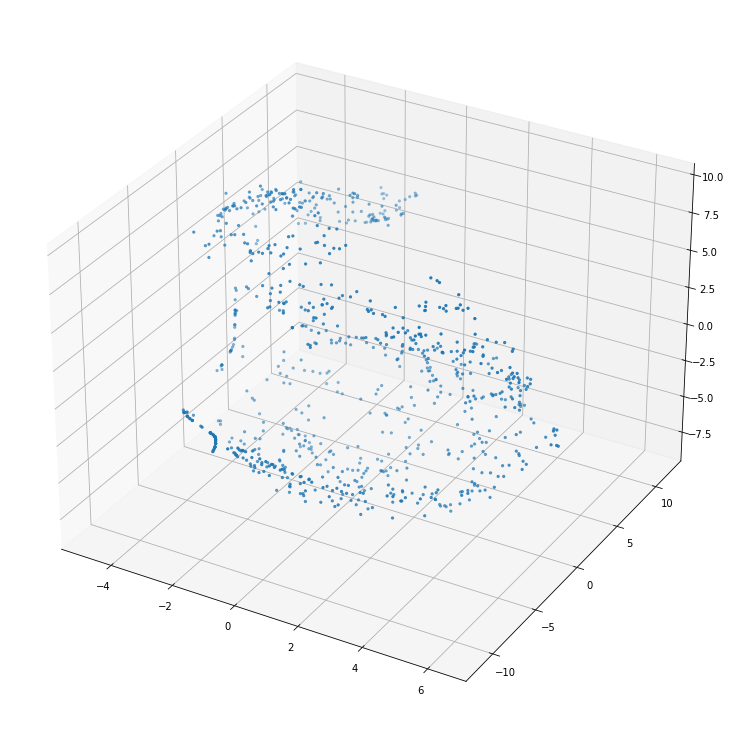

In [57]:
tsne = TSNE(n_components=3, perplexity=40, early_exaggeration=3.0,
            learning_rate=9.0, n_iter=500, n_iter_without_progress=300,
            min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
            random_state=42, method='barnes_hut', angle=0.5)
X = tsne.fit_transform(mlg)

from mpl_toolkits.mplot3d import Axes3D
dtsne = pd.DataFrame({'MSOA11CD':mlg.index,'D1':X[:,0], 'D2':X[:,1], 'D3':X[:,2]})
f = plt.figure(figsize=(10,10))
ax = Axes3D(f)
ax.scatter(dtsne.D1, dtsne.D2, dtsne.D3, marker='.')

## Clustering Data Frame

In [58]:
dtsne.head()

,MSOA11CD,D1,D2,D3
0,E02000001,-1.95,-2.26,4.43
1,E02000003,-3.93,0.84,7.44
2,E02000005,-4.62,-1.56,6.64
3,E02000007,-2.39,1.23,-3.72
4,E02000008,-4.39,4.54,3.30


In [102]:
cldf = dtsne.set_index('MSOA11CD').copy()

In [110]:
rs = pd.merge(msoas[['MSOA11CD','geometry']], cldf, on='MSOA11CD', how='inner').set_index('MSOA11CD')
rs.head()

,geometry,D1,D2,D3
MSOA11CD,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",-1.95,-2.26,4.43
E02000003,"POLYGON ((549102.438 189324.625, 548954.517 18...",-3.93,0.84,7.44
E02000005,"POLYGON ((549099.634 187656.076, 549161.375 18...",-4.62,-1.56,6.64
E02000007,"POLYGON ((549819.924 187080.699, 549950.750 18...",-2.39,1.23,-3.72
E02000008,"POLYGON ((548171.431 186545.742, 548136.262 18...",-4.39,4.54,3.30


In [111]:
cols_to_plot = np.random.choice(cldf.columns.values, 2, replace=False)
print("Plotting cols: " + ", ".join(cols_to_plot))

Plotting cols: D3, D2


[0 2 0 3 2 1 3 0 1 0 1 1 0 1 1 1 1 1 0 3 2 1 3 2 0 3 1 3 3 3 1 3 0 0 1 3 2
 1 3 0 3 2 0 1 0 1 0 0 1 0 3 3 1 3 2 2 0 2 1 3 2 1 3 3 3 3 3 1 3 1 1 3 2 0
 0 3 1 0 0 1 0 1 3 2 0 0 3 3 2 3 1 3 0 1 0 1 3 1 0 1 2 3 2 2 0 3 3 1 3 3 3
 1 3 3 3 1 3 0 3 1 3 1 1 0 3 1 3 1 0 3 3 0 2 2 2 2 0 2 0 2 0 0 0 0 3 0 0 2
 2 2 2 2 0 3 0 0 2 2 0 2 1 3 0 3 1 1 1 1 1 1 1 3 1 1 1 1 3 3 1 1 1 1 1 3 1
 1 1 1 3 1 1 1 1 1 3 3 1 3 1 1 1 3 3 3 0 1 0 2 3 0 2 0 1 0 0 0 0 1 3 0 0 0
 0 0 1 0 1 3 1 0 3 1 2 3 3 3 0 0 3 0 3 3 0 3 3 1 0 0 2 3 0 2 1 3 0 1 3 3 3
 3 1 3 2 3 1 1 0 3 3 3 3 1 2 0 2 0 2 3 1 2 1 1 1 3 3 1 3 3 3 0 3 0 0 3 3 3
 3 3 3 3 3 0 0 0 3 3 0 0 0 3 2 0 0 0 0 2 2 2 2 0 0 3 3 2 0 2 2 2 0 2 2 2 2
 3 3 1 0 3 0 3 2 1 1 2 0 1 2 2 3 2 3 3 2 3 1 1 3 0 0 3 2 3 3 2 0 0 0 1 3 0
 1 2 2 2 3 3 1 3 1 1 1 3 0 3 3 1 2 3 3 3 0 3 0 1 1 2 1 3 0 3 1 0 1 0 1 1 1
 1 0 0 3 0 1 1 0 3 0 0 0 1 3 0 1 3 1 3 1 1 1 1 3 0 2 0 1 3 2 0 3 1 3 1 3 3
 3 1 2 3 1 0 0 3 1 0 0 0 3 3 3 2 3 2 0 3 3 3 3 3 3 0 2 3 0 0 0 0 0 0 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 

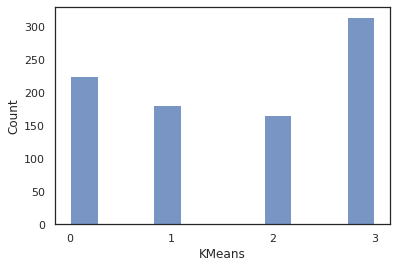

In [112]:
c_nm   = 'KMeans' # Clustering name
k_pref = 4 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
s = pd.Series(kmeans.labels_, index=cldf.index) 
rs[c_nm] = s

# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm)
plt.xticks(range(rs[c_nm].min(), math.ceil(rs[c_nm].max())+1));

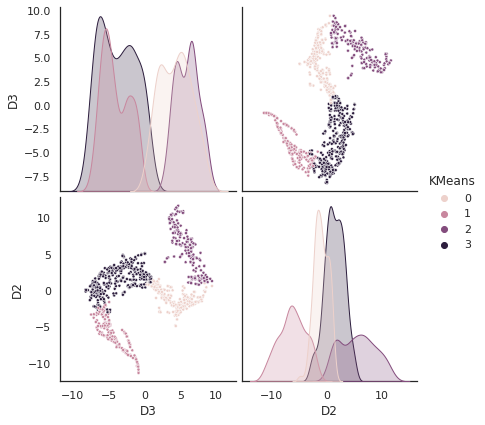

In [113]:
# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="white")
sns.pairplot(rs, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

<AxesSubplot:>

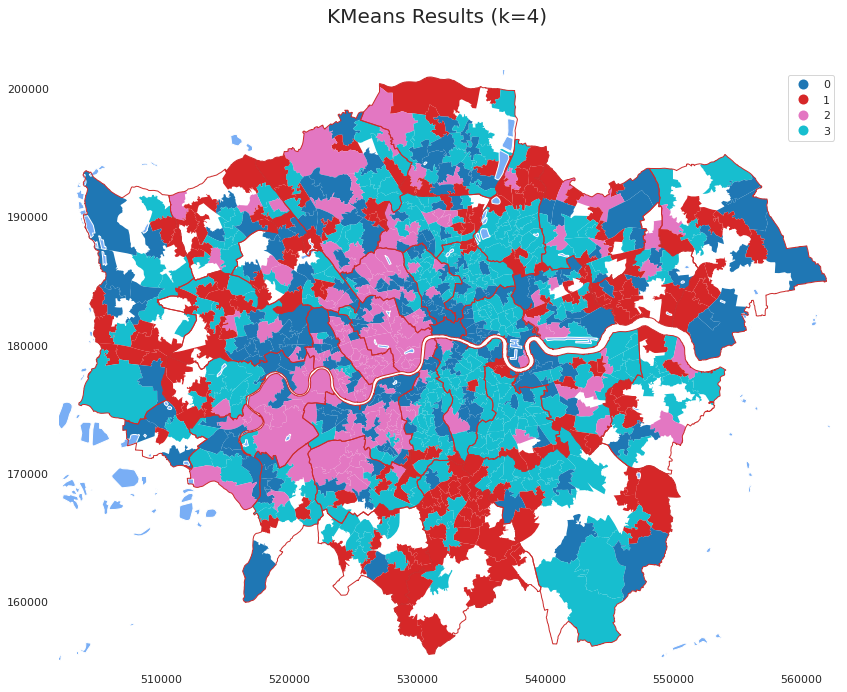

In [115]:
fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True)

One More Thing...

There's just one little problem: what assumption did I make when I started this k-means cluster analysis? It's a huge one, and it's one of the reasons that k-means clustering can be problematic when used naively...

STOP. What critical assumption did we make when running this analysis?
The 'Right' Number of Clusters
Again, there's more than one way to skin this cat. In Geocomputation they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try it for a range of values...

.......................................
Largest silhouette score was 0.4075 for k=7


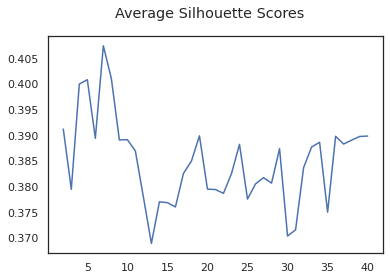

In [108]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

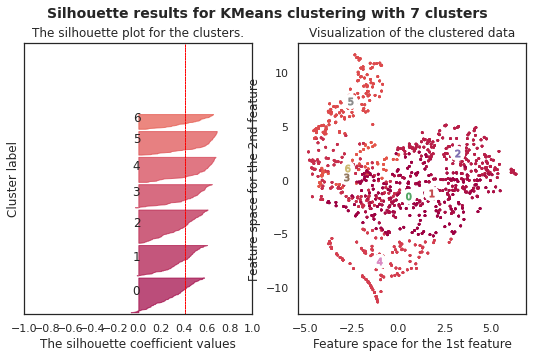

In [116]:
k_pref=7
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)

# We do this for plotting
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(cldf, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

Interpreting the Results

STOP. Make sure that you understand how the silhouette plot and value work, and why your results may diverge from mine.

We can use the largest average silhouette score to determine the 'natural' number of clusters in the data, but that that's only if we don't have any kind of underlying theory, other empirical evidence, or even just a reason for choosing a different value... Again, we're now getting in areas where your judgement and your ability to communicate your rationale to readers is the key thing.

<AxesSubplot:>

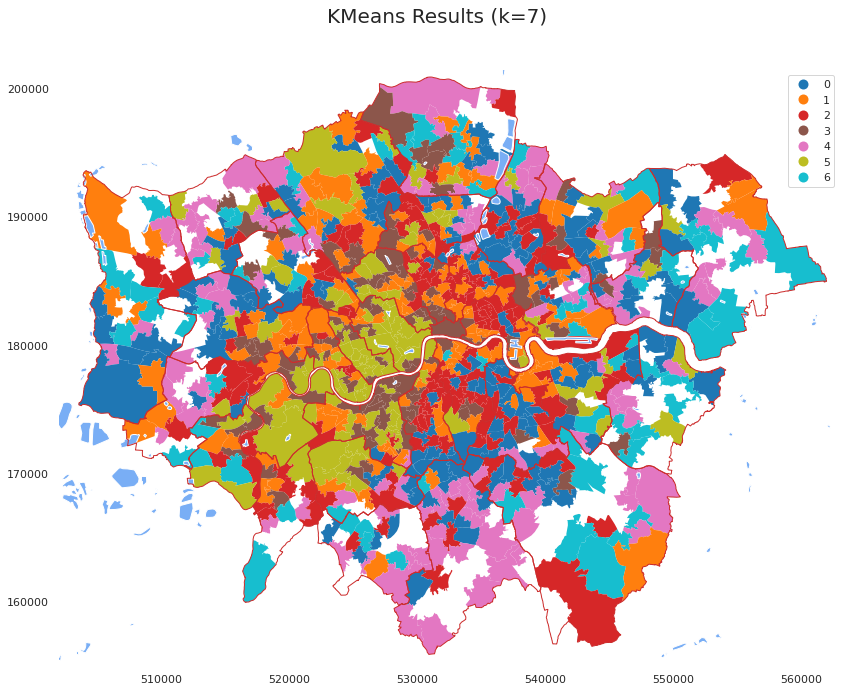

In [117]:
fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True)


'Representative' Centroids
To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of k-means this will work quite will since the clusters are explicitly built around mean centroids. There's also a k-medoids clustering approach built around the median centroid.

DBScan

Of course, as we've said above k-means is just one way of clustering, DBScan is another. Unlike k-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify other parameters (typically, these are known as hyperparameters because they are about specifying parameters that help the aglorithm to find the right solution... or final set of parameters!) and these can have a huge impact on our results!



Find a Reasonable Value for Epsilon

Before we an use DBSCAN it's useful to find a good value for Epsilon. We can look for the point of maximum 'curvature' in a nearest neigbhours plot. Which seems to be in the vicinity of 0.55. Tips on selecting min_pts can be found here.

(0.0, 2.5)

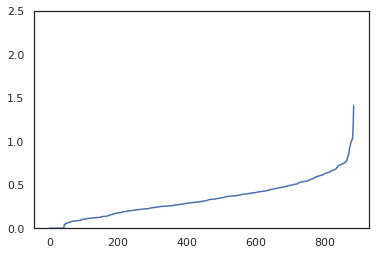

In [120]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cldf)
distances, indices = nbrs.kneighbors(cldf)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);
axes = plt.gca()
axes.set_ylim([0.0,2.5])

In [125]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.5, 1.5, 0.01):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=cldf.shape[1]+1).fit(cldf.values)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=cldf.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

0 epsilons explored.
25 epsilons explored.
50 epsilons explored.
75 epsilons explored.
Done.


In [126]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)

In [127]:
odf['Count'] = odf.Count.astype(float)

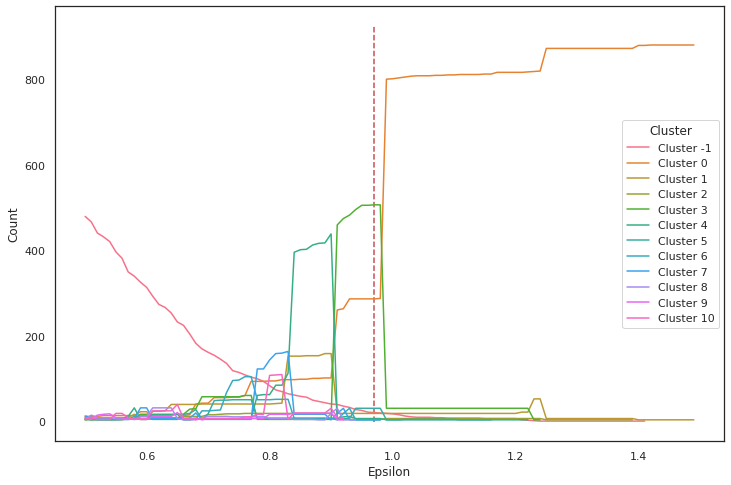

In [147]:
xmin = odf[odf.Cluster=='Cluster 0'].Epsilon.min()
xmax = odf[(odf.Cluster=='Cluster -1') & (odf.Count < cldf.shape[0]/5)].Epsilon.min()

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster', ax=ax);
ax.vlines(0.97, 0, ax.get_ylim()[1], colors='r', linestyles='dashed', label='Epsilon');

In [148]:
e = 0.97
dbs = DBSCAN(eps=e, min_samples=cldf.shape[1]+1).fit(cldf.values)
s = pd.Series(dbs.labels_, index=cldf.index, name=c_nm)
rs[c_nm] = s
print(s.value_counts())

 3    507
 0    287
 5     31
-1     21
 1     19
 4      7
 2      5
 7      4
 6      4
Name: DBSCAN, dtype: int64


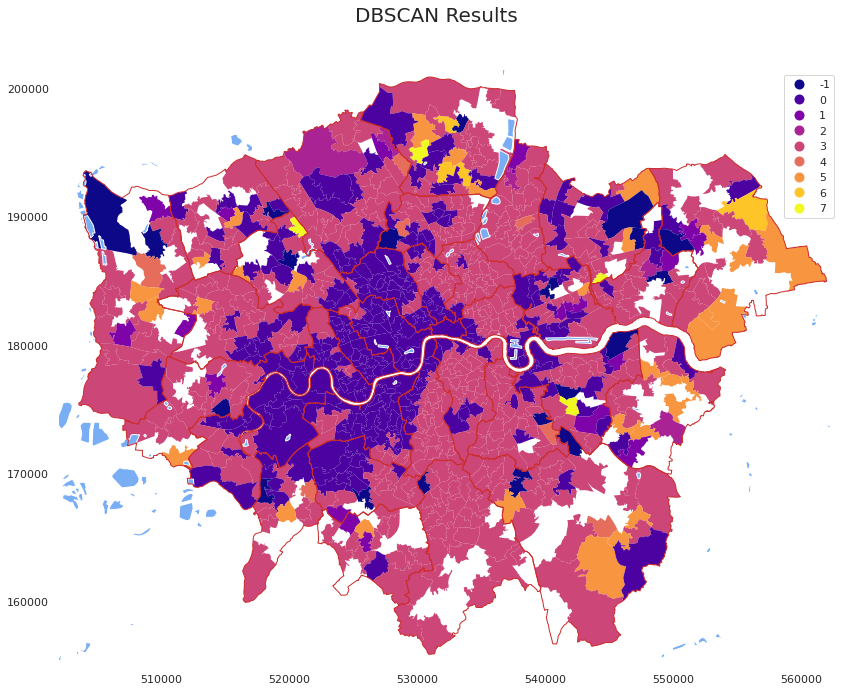

In [149]:
fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, cmap='plasma', categorical=True, legend=True);

In [150]:
from sompy.sompy import SOMFactory

In [151]:
c_nm = 'SOM'

sm = SOMFactory().build(
    cldf.values, mapsize=(10,15),
    normalization='var', initialization='random', component_names=cldf.columns.values)
sm.train(n_job=4, verbose=False, train_rough_len=2, train_finetune_len=5)

In [152]:
topographic_error  = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = {0:0.5f}; Quantization error = {1:0.5f}".format(topographic_error, quantization_error))

Topographic error = 0.06328; Quantization error = 0.28913


/opt/conda/envs/sds2020/lib/python3.7/site-packages/sompy/visualization/mapview.py:87: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(no_row_in_plot, no_col_in_plot, axis_num)


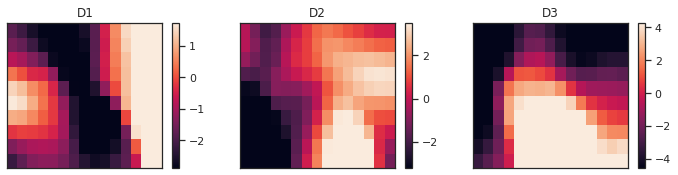

In [153]:
from sompy.visualization.mapview import View2D
view2D = View2D(10, 10, "rand data", text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)

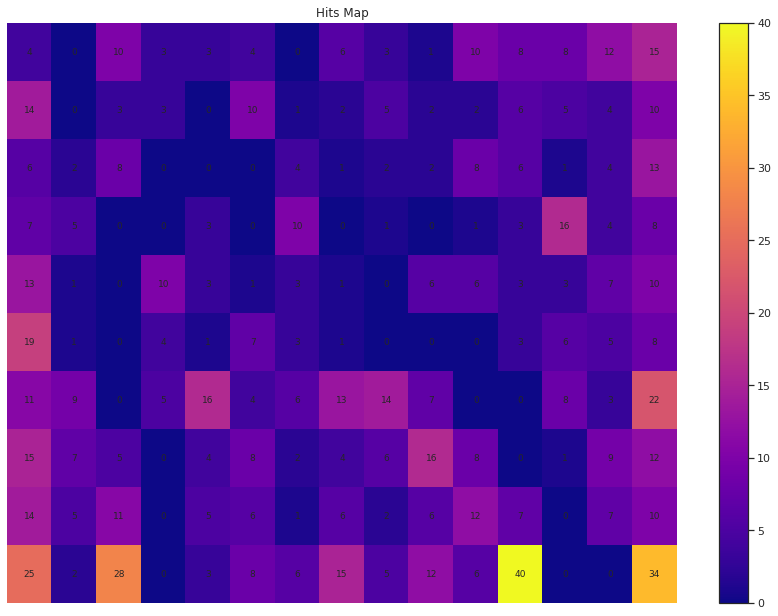

In [154]:
from sompy.visualization.bmuhits import BmuHitsView
vhts = BmuHitsView(15, 15, "Hits Map", text_size=8)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=9, cmap="plasma", logaritmic=False)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


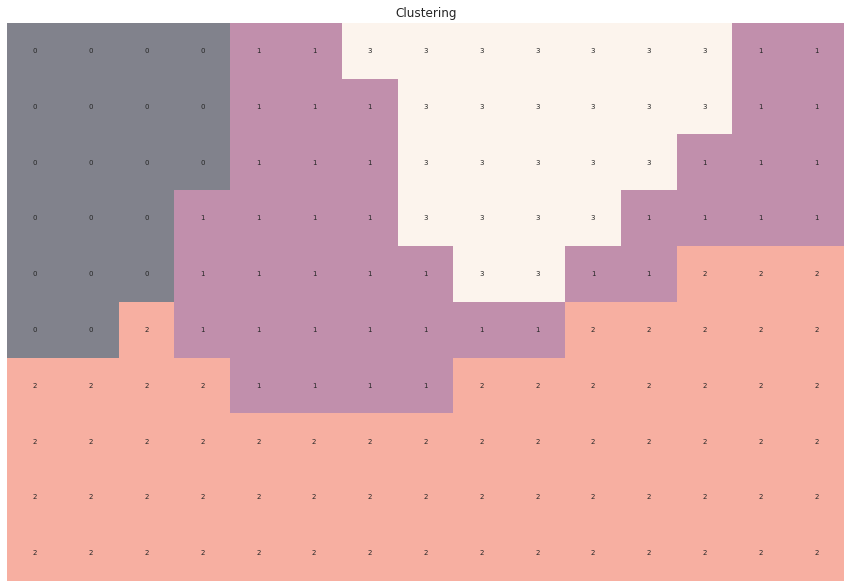

In [162]:
from sompy.visualization.hitmap import HitMapView

k_val = 4
sm.cluster(k_val)
hits  = HitMapView(15, 15, "Clustering", text_size=14)
a     = hits.show(sm)

In [163]:
# Get the labels for each BMU
# in the SOM (15 * 10 neurons)
clabs = sm.cluster_labels

# Project the data on to the SOM
# so that we get the BMU for each
# of the original data points
bmus  = sm.project_data(cldf.values)

# Turn the BMUs into cluster labels
# and append to the data frame
s = pd.Series(clabs[bmus], index=rs.index, name=c_nm)

rs[c_nm] = s

<AxesSubplot:>

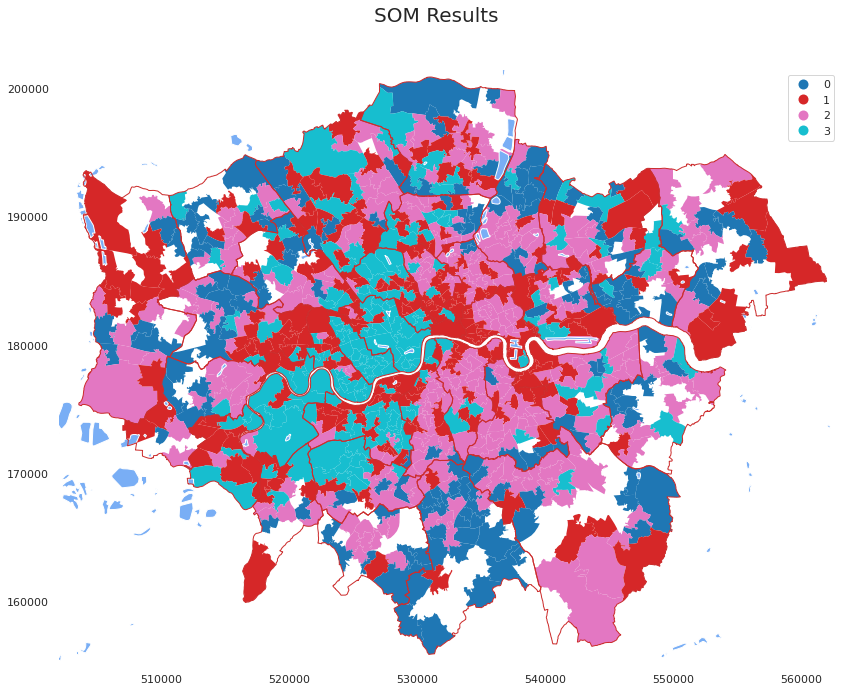

In [164]:
fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True)

### Which Clustering Approach is Right?

The reason that there is no 'right' approach to clustering is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" width="700px" /></a>

_Note:_ for geographically-aware clustering you need to look at PySAL.

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy, and so my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook an important cluster of cases because it's 'hidden' inside an area with lots of people who don't have cancer. In that case, I want my clusters to take geography into account. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

#### Ensure Plotting Output

In [ ]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

#### Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk

from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
sklv = int(sklearn.__version__.replace(".",""))
if sklv < 210:
    print("SciKit-Learn verion is: " + sklearn.__version__)
    print("The OPTICS part of this notebook relies on a version >= 0.21.0")

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
from sklearn import cluster

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [ ]:
src = 'https://github.com/kingsgeocomp/applied_gsa/blob/master/data/Census.zip?raw=true'
dst = os.path.join('analysis','Census.zip')

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    print("Downloading...")
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
else:
    print("File already downloaded.")
    
print("Done.")

### Loading the NomisWeb Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!

In [ ]:
z = zipfile.ZipFile(os.path.join('analysis','Census.zip'))
z.namelist()

We're going to save each data set to a separate data frame to make it easier to work with during cleaning. But note that this code is fairly flexible since we stick each new dataframe in a dictionary (`d`) where we can retrieve them via an iterator.

In [ ]:
raw   = {}
clean = {}
total_cols = 0

for r in range(0, len(z.namelist())):
    
    m  = re.search("(?:-)([^\.]+)", z.namelist()[r])
    nm = m.group(1)
    
    print("Processing {0} file: ".format(nm))
    
    with z.open(z.namelist()[r]) as f:
                
        if z.namelist()[r] == '99521530-Activity.csv': 
            raw[nm] = pd.read_csv(BytesIO(f.read()), header=7, skip_blank_lines=True, skipfooter=7, engine='python')
        else:
            raw[nm] = pd.read_csv(BytesIO(f.read()), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    
    print("\tShape of dataframe is {0} rows by {1} columns".format(raw[nm].shape[0], raw[nm].shape[1]))
    total_cols += raw[nm].shape[1]

print("There are {0} columns in all.".format(total_cols))

In [ ]:
nm  = 'Occupation'
url = 'https://github.com/jreades/urb-studies-predicting-gentrification/raw/master/data/src/2011/ks610ew.csv.gz'

print(f"Processing {nm}")
df = pd.read_csv(url, header=7, skip_blank_lines=True, compression='gzip', low_memory=False)
mapping = {
    '1. Managers, directors and senior officials':'Managers',
    '2. Professional occupations':'Professionals',
    '3. Associate professional and technical occupations':'Associates',
    '4. Administrative and secretarial occupations':'Administrative',
    '5. Skilled trades occupations':'Skilled trades',
    '6. Caring, leisure and other service occupations':'Caring and Leisure',
    '7. Sales and customer service occupations':'Customer Service',
    '8. Process plant and machine operatives':'Operatives',
    '9. Elementary occupations':'Elementary'
}
df.rename(columns=mapping, inplace=True)
df.drop(['2011 super output area - lower layer','All categories: Occupation'], axis=1, inplace=True)

raw[nm] = df
df.sample(3, random_state=42)

In [ ]:
nm  = 'Income'
url  = 'https://data.london.gov.uk/download/household-income-estimates-small-areas/7c1099d9-327b-4f20-abb8-8c24a3c10c47/modelled-household-income-estimates-lsoa.csv'

print(f"Processing {nm}")
df = pd.read_csv(url, encoding='latin-1')[['Code','Median 2011/12']]
df['Median Income'] = df['Median 2011/12'].str.replace('£','').str.replace(',','').astype('float')
df.drop('Median 2011/12', axis=1, inplace=True)

raw[nm] = df
df.sample(3, random_state=42)

In [ ]:
nm  = 'Housing'
url = 'https://data.london.gov.uk/download/average-house-prices/9a92fbaf-c04e-498a-9f8c-6c85f280817e/land-registry-house-prices-LSOA.csv'

print(f"Processing {nm}")
df = pd.read_csv(url, encoding='latin-1', low_memory=False)

df['Borough'] = df.Area.str.replace(' [0-9A-Z]{4}$','')
df.drop('Area', axis=1, inplace=True)

df = df[ (df.Year=='Year ending Dec 2011') & (df.Measure=='Median') ][['Code','Value','Borough']]

# Note: not all have a value for this year!
df['Median House Price'] = df.Value.str.replace(':','-1').astype(float)

la = df.groupby('Borough')
la_prices = pd.DataFrame(la['Median House Price'].median())

df = df.join(la_prices, how='inner', on='Borough', rsuffix='_la')

df.loc[df['Median House Price'] < 50000,'Median House Price'] =  df[df['Median House Price'] < 50000]['Median House Price_la']
df.drop(['Value','Borough','Median House Price_la'], inplace=True, axis=1)

raw[nm] = df
df.sample(3, random_state=42)

### ONS Boundary Data

We also need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

#### Saving Time

Again, in order to get you started more quickly I've already created a 'pack' for you. However, note that the format of this is a GeoPackage, this is a fairly new file format designed to replace ESRI's antique Shapefile format, and it allows us to include all kinds of useful information as part of the download as well as doing away with the need to unzip a download first! So here we load the data directly into a geopandas dataframe:

In [ ]:
src = 'https://github.com/kingsgeocomp/applied_gsa/raw/master/data/London%20LSOAs.gpkg'

gdf = gpd.read_file(src)
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.columns = [x.lower() for x in gdf.columns.values]
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.sample(4)

#### <span style="color:red">Error!</span>

Depending on your version of GDAL/Fiona, you may not be able to read the GeoPackage file directly. In this case you will need to replace the code above with the code below for downloading and extracting a Shapefile from a Zip archive:
```python
src = 'https://github.com/kingsgeocomp/applied_gsa/blob/master/data/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.zip?raw=true'
dst = os.path.join('analysis','LSOAs.zip')
zpd = 'analysis'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))

    r = requests.get(src, stream=True)

    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()

gdf = gpd.read_file(os.path.join('analysis','lsoas','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp'))
gdf.crs = {'init' :'epsg:27700'}
print(\"Shape of LSOA file: {0} rows by {1} columns\".format(gdf.shape[0], gdf.shape[1]))
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.sample(4)
```

You can probably see why I'm a big fan of GeoPackages when they're available!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking (though I haven't used it) [wrapper to the Census API](https://pypi.python.org/pypi/census). And [Spielman and Singleton](https://www.tandfonline.com/doi/full/10.1080/00045608.2015.1052335) have done some work on large-scale geodemographic clustering of U.S. Census geographies.

### Direct Downloads

These are already clean, so we can just copy them over.

In [ ]:
for t in ['Occupation','Housing','Income']:
    raw[t].rename(columns={'Code':'mnemonic'}, inplace=True)
    print(raw[t].columns)
    clean[t] = raw[t]

### Dwellings

From dwellings we're mainly interested in the housing type since we would expect that housing typologies will be a determinant of the types of people who live in an area. We _could_ look at places with no usual residents as well, or explore the distribution of shared dwellings, but this is a pretty good start.

In [ ]:
t = 'Dwellings'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Whole house or bungalow: Detached', 
    'Whole house or bungalow: Semi-detached',
    'Whole house or bungalow: Terraced (including end-terrace)',
    'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
    'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
    'Flat, maisonette or apartment: In a commercial building'
]

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

mapping = {}
for c in selection[1:]:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?([^\(]+)", c)
    nm = m.group(1).strip()
    #print("Renaming '{0}' to '{1}'".format(c, nm))
    mapping[c] = nm

clean[t].rename(columns=mapping, inplace=True)

clean[t].sample(5, random_state=42)

### Age

Clearly, some areas have more young people, some have older people, and some will be composed of families. A lot of these are going to be tied to 'lifestage' and so will help us to understand something about the types of areas in which they live.

In [ ]:
t = 'Age'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Age 0 to 14',
    'Age 15 to 24',
    'Age 25 to 44',
    'Age 45 to 64',
    'Age 65+'
]

# Derived columns
raw[t]['Age 0 to 14']  = raw[t]['Age 0 to 4'] + raw[t]['Age 5 to 7'] + raw[t]['Age 8 to 9'] + raw[t]['Age 10 to 14'] 
raw[t]['Age 15 to 24'] = raw[t]['Age 15'] + raw[t]['Age 16 to 17'] + raw[t]['Age 18 to 19'] + raw[t]['Age 20 to 24']
raw[t]['Age 25 to 44'] = raw[t]['Age 25 to 29'] + raw[t]['Age 30 to 44']
raw[t]['Age 45 to 64'] = raw[t]['Age 45 to 59'] + raw[t]['Age 60 to 64']
raw[t]['Age 65+']      = raw[t]['Age 65 to 74'] + raw[t]['Age 75 to 84'] + raw[t]['Age 85 to 89'] + raw[t]['Age 90 and over']

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

clean[t].sample(5, random_state=42)

### Ethnicity

We might also think that the balance of ethnic groups might impact a categorisation of LSOAs in London.

In [ ]:
t = 'Ethnicity'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'White', 
    'Mixed/multiple ethnic groups', 
    'Asian/Asian British', 
    'Black/African/Caribbean/Black British', 
    'Other ethnic group'
]

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

clean[t].sample(5, random_state=42)

### Rooms

Let's next incorporate the amount of space available to each household.

In [ ]:
t = 'Rooms'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Occupancy rating (bedrooms) of -1 or less',
    'Occupancy rating (rooms) of -1 or less',
    'Average household size', 
#    'Average number of bedrooms per household',
#    'Average number of rooms per household',
]

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

clean[t].sample(5, random_state=42)

### Vehicles

Car ownership and use is also known to be a good predictor of social and economic 'status': Guy Lansley's article on the DLVA's registration database offers a useful perpective on the usefulness of this approach.

In [ ]:
t = 'Vehicles'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'No cars or vans in household', 
    '1 car or van in household',
    '2 cars or vans in household', 
    '3 or more cars or vans in household'
]

# Calculate a new column
raw[t]['3 or more cars or vans in household'] = raw[t]['3 cars or vans in household'] + raw[t]['4 or more cars or vans in household']

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

clean[t].sample(5, random_state=42)

### Tenure

Ownership structure is another categorisation predictor.

In [ ]:
t = 'Tenure'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Owned', 
    'Social rented', 
    'Private rented',
    'Shared ownership (part owned and part rented)'
]

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

clean[t].rename(columns={'Shared ownership (part owned and part rented)':'Shared ownership'}, inplace=True)

clean[t].sample(5, random_state=42)

### Qualifications

You can find out a bit more about qualifications [here](https://www.surreyi.gov.uk/2011-census/highest-level-of-qualification/#header-qualifications-categories).

In [ ]:
t = 'Qualifications'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Highest level of qualification: Below Level 3 qualifications',
    'Highest level of qualification: Level 3 and above qualifications',
    'Highest level of qualification: Other qualifications'
]

# Derive a new aggregate field for 'didn't complete HS'
raw[t]['Highest level of qualification: Below Level 3 qualifications'] = \
    raw[t]['No qualifications'] + \
    raw[t]['Highest level of qualification: Level 1 qualifications'] + \
    raw[t]['Highest level of qualification: Level 2 qualifications'] + \
    raw[t]['Highest level of qualification: Apprenticeship'] 

raw[t]['Highest level of qualification: Level 3 and above qualifications'] = \
    raw[t]['Highest level of qualification: Level 3 qualifications'] + \
    raw[t]['Highest level of qualification: Level 4 qualifications and above']

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

mapping = {}
for c in selection[1:]:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?([^\(]+)", c)
    nm = m.group(1).strip()
    #print("Renaming '{0}' to '{1}'".format(c, nm))
    mapping[c] = nm

clean[t].rename(columns=mapping, inplace=True)

clean[t].sample(5, random_state=42)

### Activity

In [ ]:
t = 'Activity'
raw[t].columns

In [ ]:
# Select the columns we're interested in analysing
selection = ['mnemonic',
    'Economically active: In employment',
    'Economically active: Unemployed',
    'Economically active: Full-time student',
#    'Economically inactive: Retired',
    'Economically inactive: Looking after home or family',
    'Economically inactive: Long-term sick or disabled',
#    'Economically inactive: Other'
]

# Drop everything *not* in the selection
clean[t] = raw[t].drop(raw[t].columns[~np.isin(raw[t].columns.values,selection)].values, axis=1)

mapping = {}
for c in selection[1:]:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?([^\(]+)", c)
    nm = m.group(1).strip()
    #print("Renaming '{0}' to '{1}'".format(c, nm))
    mapping[c] = nm

clean[t].rename(columns=mapping, inplace=True)

clean[t].sample(5, random_state=42)

### Standardisation with SKLearn

Let's try standardising the data now:

In [ ]:
# Here's how we can rescale and transform data easily
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
random.seed(42)
t   = random.sample(population=list(clean.keys()), k=1)[0]
col = random.sample(population=list(clean[t].columns.values[1:]), k=1)[0]
print(f"Looking at {col} column from {t}.")

Here's the 'original' distribution:

In [ ]:
plt.rcParams['figure.figsize']=(7,3)
sns.distplot(clean[t][col], kde=False)

Here's the version that has been re-scaled (standardised) using Min/Max rescaling:

In [ ]:
plt.rcParams['figure.figsize']=(7,3)
sns.distplot(preprocessing.minmax_scale(clean[t][col].values.reshape(-1,1)), kde=False)

Here's a version that has been robustly rescaled:

In [ ]:
plt.rcParams['figure.figsize']=(7,3)
sns.distplot(preprocessing.robust_scale(clean[t][col].values.reshape(-1,1), quantile_range=[5.0, 95.0]), kde=False)

And here's a version that has been Power Transformed... spot the difference!

In [ ]:
sns.distplot(
    preprocessing.power_transform(clean[t][col].values.reshape(-1,1), method='yeo-johnson'), kde=False)

Combining transformation _and_ rescaling:

In [ ]:
sns.distplot(
    preprocessing.robust_scale(
        preprocessing.power_transform(
            clean[t][col].values.reshape(-1,1), method='yeo-johnson'
        ), quantile_range=[5.0, 95.0] 
    ), 
    kde=False
)

In [ ]:
# Set up a new dictionary for the transforms
transformed = {}

transformer = preprocessing.PowerTransformer()
scaler      = preprocessing.RobustScaler(quantile_range=[5.0, 95.0])
#scaler      = preprocessing.MinMaxScaler()

# Simple way to drop groups of data we don't want...
suppress       = set(['Rooms','Vehicles'])

for k in set(clean.keys()).difference(suppress):
    print(f"Transforming {k}")
    df = clean[k].copy(deep=True)
    df.set_index('mnemonic', inplace=True)
    
    # For rescale and transforming everything when the operations
    # apply to each Series separately you can do it as a 1-liner like this:
    #df[df.columns] = scaler.fit_transform(transformer.fit_transform(df[df.columns]))

    # To calculate within-*column* proportions it's like this:
    #for c in df.columns.values: 
    #    df[c] = scaler.fit_transform( (df[c]/df[c].max() ).values.reshape(-1, 1) )

    # To calculate within-*group* proportions it's like this:
    if k in ['Housing','Income','Rooms']:
        df[df.columns] = scaler.fit_transform( df[df.columns] )
    else: 
        df['sum'] = df[list(df.columns)].sum(axis=1)
        for c in df.columns.values:
            if c == 'sum':
                df.drop(['sum'], axis=1, inplace=True)
            else:
                df[c] = scaler.fit_transform( (df[c]/df['sum']).values.reshape(-1, 1) )
            
    #print(df.sample(5, random_state=42))
    transformed[k] = df


### Creating the Single Data Set

Now that we've converted everything to percentages, it's time to bring the data together! We'll initialise the data frame using the first matching data set, and then iterate over the rest, merging the data frames as we go.

In [ ]:
matching = list(transformed.keys())
print("Found the following data sets:\n\t" + ", ".join(matching))

# Initialise the data frame simply by grabbing the
# very first existing data frame and copying it 
# directly (SCaled Data Frame == scdf)
scdf  = transformed[matching[0]].copy() 
lsoac = clean[matching[0]].copy() 

for m in range(1, len(matching)):
    scdf  = scdf.merge(transformed[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')
    lsoac = lsoac.merge(clean[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')

scdf.to_csv(os.path.join('data','Scaled_and_Transformed.csv.gz'), compression='gzip')
lsoac.to_csv(os.path.join('data','Cleaned.csv.gz'), compression='gzip')

In [ ]:
print("Shape of full data frame is {0} by {1}".format(scdf.shape[0], scdf.shape[1]))

With luck you still have 4,835 rows, but now you have rather fewer than 88 columns.

In [ ]:
random.seed(42)
cols_to_plot = random.sample(population=list(scdf.columns.values), k=3)
print("Columns to plot: " + ", ".join(cols_to_plot))

In [ ]:
# The data as it is now...
sns.set(style="whitegrid")
sns.pairplot(lsoac, 
             vars=cols_to_plot, 
             markers=".", height=3, diag_kind='kde')

In [ ]:
# The data as it is now...
sns.set(style="whitegrid")
sns.pairplot(scdf, 
             vars=cols_to_plot, 
             markers=".", height=3, diag_kind='kde')

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Making sure that you understand how and why this results differns from the <i>same</i> plot above.</div>

Right, so you can see that rescaling the dimension hasn't *actually* changed the relationships within each dimension, or even between dimensions, but it has changed the overall range so that the the data is broadly re-centered on 0 but we *still* have the original outliers from the raw data. You could _also_ do IQR standardisation (0.25 and 0.75) with the percentages, but in those cases you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

#### Freeing Up Memory

We now have quite a few variables/datasets in memory, so it's a good idea to free up some RAM by getting rid of anything we no longer need...

In [ ]:
in_scope  = set([x for x in dir() if not x.startswith('_')])
to_delete = set(['raw','clean','transformed','col','k','c','lsoac','scdf'])
z = list(in_scope.intersection(to_delete))
del(z)

#### Clustering Your Data

OK, we're finally here! It's time to cluster the cleaned, normalised, and standardised data set! We're going to start with the best-known clustering technique (k-means) and work from there... Don't take my word for it, here are the [5 Clustering Techniques Every Data Scientist Should Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68). This is also a good point to refer back to some of what we've been doing (and it's a good point to potentially disagree with me!) since [clustering in high dimensions can be problematic](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6) (_i.e._ the more dimensions the worse the Euclidean distance gets as a cluster metric).

The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">Unfortunately, our data is a <i>lot</i> messier and has many more dimensions (>25) than this.</div>

- Find the appropriate eps value: [Nearest Neighbour Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Nearest-Neighbor-Distance-Functions)

#### Brief Discussion

In the practical I've followed the _Geocomputation_ approach of basically converting everything to a share (percentage) and then clustering on that. This is _one_ way to approach this problem, but there are _many_ others. For instance, many people might skip the percentages part and apply robust rescaling ([`sklearn.preprocessing.RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)) using centering and quantile standardisation (the 5th and 95th, for example) instead. And possibly using a normalising transformation (such as a [Power Transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)) as well. 

I would also consider using PCA on groups of related variables (_e.g._ the housing features as a group, the ethnicity features as a group, etc.) and then take the first few eigenvalues from each group and cluster on all of those together. This would remove quite a bit of the correlation between variables and still allow us to perform hierarchical and other types of clustering on the result. It might also do a better job of preserving outliers.

#### Create an Output Directory and Load the Data

In [ ]:
o_dir = os.path.join('outputs','clusters')
if os.path.isdir(o_dir) is not True:
    print("Creating '{0}' directory.".format(o_dir))
    os.makedirs(o_dir)

In [ ]:
df = pd.read_csv(os.path.join('data','Scaled_and_Transformed.csv.gz'))
df.rename(columns={'mnemonic':'lsoacd'}, inplace=True)
df.set_index('lsoacd', inplace=True)
df.describe()

In [ ]:
df.sample(3, random_state=42)

#### Grab Borough Boundaries and Water Courses

_Note:_ if reading these GeoPackages gives you errors then you will need to comment out the following two lines from the `plt_ldn` function immediately below:
```python
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
```

In [ ]:
# Load Water GeoPackage
w_path = os.path.join('data','Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/kingsgeocomp/applied_gsa/raw/master/data/Water.gpkg')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('data','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/kingsgeocomp/applied_gsa/raw/master/data/Boroughs.gpkg')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

#### Useful Functions for Plotting

In [ ]:
def plt_ldn(w=water, b=boroughs):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

#### Select 4 Columns to Plot

In [ ]:
random.seed(42)
cols_to_plot = random.sample(population=list(df.columns.values), k=4)
print("Columns to plot: " + ", ".join(cols_to_plot))

#### Storing Results

In [ ]:
result_set = None

def add_2_rs(s, rs=result_set):
    if rs is None:
        # Initialise
        rs = pd.DataFrame()
    rs[s.name] = s
    return rs

### K-Means

#### Importing the Library

In [ ]:
from sklearn.cluster import KMeans
#help(KMeans)

The next few code blocks may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. I've reduced the plotting to just three dimensions, if you want to plot all of them, then just replace the array attached to `vars` with `main_cols`, but you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! It'll take a while, but it _will_ do it, and try doing that in Excel or SPSS?

#### A First Cluster Analysis

In [ ]:
c_nm   = 'KMeans' # Clustering name
k_pref = 6 # Number of clusters

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

kmeans = KMeans(n_clusters=k_pref, n_init=20, random_state=42, n_jobs=-1).fit(cldf) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
cldf[c_nm] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
cldf[c_nm].hist(bins=k_pref)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="white")
sns.pairplot(cldf, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde')

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(0,cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))

norm    = mpl.colors.BoundaryNorm(breaks, cmap.N)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

del(cgdf)

#### One More Thing...

There's just _one_ little problem: what assumption did I make when I started this *k*-means cluster analysis? It's a huge one, and it's one of the reasons that *k*-means clustering _can_ be problematic when used naively...

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. What critical assumption did we make when running this analysis?</div>

#### The 'Right' Number of Clusters

Again, there's more than one way to skin this cat. In _Geocomputation_ they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (`2...n`) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always _some_ benefit to adding more clusters (the perfect clustering is _k==n_), so you don't always see a knee. 

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM). 

Either way, to evaluate this in a systematic way, we want to do _multiple_ _k_-means clusterings for _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-9.

In [ ]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

text = []

for k in range(3,10):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, n_init=15, random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, cluster_labels)
    text = text + [f"For k={k} the average silhouette_score is: {silhouette_avg:6.4f}"]
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(cldf, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Set the color ramp
        #cmap  = cm.get_cmap("Spectral")
        color = plt.cm.Spectral(i/k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(cluster_labels.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

print("\n".join(text))    

del(cldf)

#### Interpreting the Results

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Make sure that you understand how the silhouette plot and value work, and why your results may diverge from mine.</div>

We can use the largest average silhouette score to determine the 'natural' number of clusters in the data, but that that's only if we don't have any kind of underlying _theory_, other _empirical evidence_, or even just a _reason_ for choosing a different value... Again, we're now getting in areas where _your judgement_ and your ability to _communicate your rationale_ to readers is the key thing. 

#### Final Clustering

Let's repeat the clustering process _one more time_ using the silhouette score as a guide and then map it.

In [ ]:
c_nm = 'KMeans'
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

k_pref = 4
kmeans = KMeans(n_clusters=k_pref, n_init=75, random_state=42).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)

# We do this for plotting
cldf[c_nm] = s

# We do this to keep track of the results
result_set=add_2_rs(s)

#### Mapping Results

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(0,cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))

norm    = mpl.colors.BoundaryNorm(breaks, cmap.N)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

plt.savefig(os.path.join(o_dir,f"{c_nm}-{k_pref}.png"), dpi=200)
del(cgdf)

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. 

You could also think of ways of plotting how these groups differ. For instance...

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of _k_-means this will work quite will since the clusters are explicitly built around mean centroids. There's also a _k_-medoids clustering approach built around the median centroid.

In [ ]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids, cldf)

### DBScan

Of course, as we've said above _k_-means is just one way of clustering, DBScan is another. Unlike _k_-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify _other_ parameters (typically, these are known as _hyperparameters_ because they are about specifying parameters that help the aglorithm to find the right solution... or final set of parameters!) and these can have a huge impact on our results!

#### Importing the Library

In [ ]:
from sklearn.cluster import DBSCAN
#?DSCAN

#### Find a Reasonable Value for Epsilon

Before we an use DBSCAN it's useful to find a good value for Epsilon. We can [look for the point of maximum 'curvature'](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) in a nearest neigbhours plot. Which seems to be in the vicinity of 0.55. Tips on selecting `min_pts` can be [found here](https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80).

In [ ]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cldf)
distances, indices = nbrs.kneighbors(cldf)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Exploration

There are two values that need to be specified: `eps` and `min_samples`. Both seem to be set largely by trial and error. It's easiest to set `min_samples` first since that sets a floor for your cluster size and then `eps` is basically a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. This next step may take quite a lot of time since we are iterating through many, many values of Epsilon to explore how the clustering result changes and how well this matches up with (or doesn't) the graph above.</div>

In [ ]:
c_nm = 'DBSCAN'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

# There's an argument for making min_samples = len(df.columns)+1

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.15, 1.55, 0.01):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=12, n_jobs=-1).fit(cldf.values)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=cldf.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    for c in range(-1, max_clusters+1):
        try:
            row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])
edf.sample(random_state=42)

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

In [ ]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)       

In [ ]:
xmin = odf[odf.Cluster=='Cluster 0'].Epsilon.min()
xmax = odf[(odf.Cluster=='Cluster -1') & (odf.Count < cldf.shape[0]/5)].Epsilon.min()

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim([xmin,xmax])
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster')

#### Final Clustering

In [ ]:
e = 0.835
dbs = DBSCAN(eps=e, min_samples=12, n_jobs=-1).fit(cldf.values)
s = pd.Series(dbs.labels_, index=cldf.index, name=c_nm)
cldf[c_nm] = s
result_set=add_2_rs(s)
print(s.value_counts())

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks), outliers=True)
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks, outliers=True)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). For algorithms other than _k_-means it may be better to use medians than means.

In [ ]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

# Drop outliers
odf = odf[odf.Cluster >= 0]

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids)

### OPTICS Clustering

This is a fairly new addition to `sklearn` and is similar to DBSCAN in that there are very few (if any) parameters to specify. This means that we're making fewer assumptions about the nature of any clustering in the data. It also allows us to have outliers that don't get assigned to _any_ cluster. The focus is mainly on local density, so in some sense it's more like a geographically aware clustering approach, but applied in the data space, not geographical space.

#### Importing the Library

In [ ]:
from sklearn.cluster import OPTICS

#### Final Clustering

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. This next step may take quite a lot of time since the algorithm is making far fewer assumptions about the structure of the data. On a 2018 MacBook Pro with 16GB of RAM it took about 5 minutes.</div>

In [ ]:
c_nm = 'Optics'

# Can try to set this from DBSCAN results
e = 0.9850

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

import math

# Run the clustering
opt = OPTICS(min_samples=len(df.columns)+1, max_eps=math.ceil(e * 100)/100, n_jobs=-1).fit(cldf.values)

# See how we did
s = pd.Series(opt.labels_, index=cldf.index, name=c_nm)
cldf[c_nm] = s
result_set=add_2_rs(s)

# Distribution
print(s.value_counts())

#### Mapping Clustering Results

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. My sense is that these results are a bit rubbish: the majority of items are assigned to <i>one cluster</i>??? I've tried PCA on the standardised data and that made little difference. This should also have worked <i>better</i> but it seems that a small number of LSOAs are so utterly different that the more sophisticated clustering algorithm effectively 'chokes' on them.</div>

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks), outliers=True)
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks, outliers=True)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). For algorithms other than _k_-Means it may be better to use medians, not means.

In [ ]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids)

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">STOP. Aside from the fact that we should probably reduce the number of dimensions on which we're clustering, what about the process of selecting variables (a.k.a. feature selection) might have led to the result that our results are a bit crap? <i>Hint: how did we decide what to keep and what to drop, and is this a robust approach?</i></div>

### HDBSCAN

Not implemented, but you could give it a try after installing the package:
```bash
conda activate <your environment name here>
conda install -c conda-forge sklearn-contrib-hdbscan
```

Then it should be something like:
```python
import hdbscan
clusterer = hdbscan.HDBSCAN()
# HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
#    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
clusterer.fit(<data>)
clusterer.labels_
```

### Hierarchical Clustering

Probably not appropriate as it tends to be confused by noise.

### Self-Organising Maps

SOMs offer a third type of clustering algorithm. They are a relatively 'simple' type of neural network in which the 'map' (of the SOM) adjusts to the data: we're going to see how this works over the next few code blocks, but the main thing is that, unlike the above approaches, SOMs build a 2D map of a higher-dimensional space and use this as a mechanism for subsequently clustering the raw data. In this sense there is a conceptual link between SOMs and PCA or tSNE (another form of dimensionality reduction).

#### (Re)Installing SOMPY

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. The maintainers of the main SOMPY library are fairly inactive, so we've had to write our own version that fixes a few Python3 bugs, but this means that it can't be installed the 'usual' way without also having Git installed. Consequently, I have left the output from SOMPY in place so that you can see what it will produce <i>even if you cannot successfully install SOMPY during this practical</i></div>. 

To work out if there is an issue, check to see if the `import` statement below gives you errors:

In [ ]:
from sompy.sompy import SOMFactory

If this import has failed with a warning about being unable to find SOM or something similar, then you will need to *re*-install SOMPY using a fork that I created on our Kings GSA GitHub account. For *that* to work, you will need to ensure that you have `git` installed. 

If the following Terminal command (which should also work in the Windows Terminal) does not give you an error then `git` is already installed:
```shell
git --version
```
To install `git` on a Mac is fairly simple. Again, from the Terminal issue the following command:
```shell
xcode-select --install
```
This installation may take some time over eduroam since there is a lot to download.

Once that's complete, you can move on to installing SOMPY from our fork. On a Mac this is done on the Terminal with:
```shell
conda activate <your kernel name here>
pip install -e git+git://github.com/kingsgeocomp/SOMPY.git#egg=SOMPY
conda deactivate
```
On Windows you probably drop the `conda` part of the command.

#### Training the SOM

We are going to actually train the SOM using the input data. This is where you specify the input parameters that have the main effect on the clustering results.

In [ ]:
from sompy.sompy import SOMFactory

In [ ]:
c_nm = 'SOM'

# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
cldf = df.drop(list(df.columns[df.isnull().any().values].values), axis=1)

sm = SOMFactory().build(
    cldf.values, mapsize=(10,15),
    normalization='var', initialization='random', component_names=cldf.columns.values)
sm.train(n_job=4, verbose=False, train_rough_len=2, train_finetune_len=5)

How good is the fit?

In [ ]:
topographic_error  = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = {0:0.5f}; Quantization error = {1:0.5f}".format(topographic_error, quantization_error))

How do the results look?

In [ ]:
from sompy.visualization.mapview import View2D
view2D = View2D(10, 10, "rand data", text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)
plt.savefig(os.path.join(o_dir, f"{c_nm}-Map.png"), dpi=200)

#### Here's What I Got

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. These are the results from the approach that is closest to the one outlined in <i>Geocomputation</i>.</div>

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/SOM-Map.png" alt="SOM Clustering Results" width="800" />

How many data points were assigned to each BMU?

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts = BmuHitsView(15, 15, "Hits Map", text_size=8)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=9, cmap="plasma", logaritmic=False)
plt.savefig(os.path.join(o_dir,f"{c_nm}-BMU Hit View.png"), dpi=200)

#### BMU Hit Map

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. These are the results from the approach that is closest to the one outlined in <i>Geocomputation</i>.</div>

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/SOM-BMU Hit View.png" alt="SOM Heat Map Results" width="800" />

How many clusters do we want and where are they on the map?

In [ ]:
from sompy.visualization.hitmap import HitMapView

k_val = 5
sm.cluster(k_val)
hits  = HitMapView(15, 15, "Clustering", text_size=14)
a     = hits.show(sm)
plt.savefig(os.path.join(o_dir,f"{c_nm}-Hit Map View.png"), dpi=200)

#### Clustering the BMUs

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. These are the results from the approach that is closest to the one outlined in <i>Geocomputation</i>.</div>

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/SOM-Hit Map View.png" alt="SOM Clustering Results" width="800" />

Finally, let's get the cluster results and map them back on to the data points:

In [ ]:
# Get the labels for each BMU
# in the SOM (15 * 10 neurons)
clabs = sm.cluster_labels

try:
    cldf.drop(c_nm,inplace=True,axis=1)
except KeyError:
    pass

# Project the data on to the SOM
# so that we get the BMU for each
# of the original data points
bmus  = sm.project_data(cldf.values)

# Turn the BMUs into cluster labels
# and append to the data frame
s = pd.Series(clabs[bmus], index=cldf.index, name=c_nm)

cldf[c_nm] = s
result_set = add_2_rs(s)

In [ ]:
cgdf = gdf.join(cldf, how='inner')

breaks = np.arange(cldf[c_nm].min(),cldf[c_nm].max()+2,1)
cmap   = default_cmap(len(breaks))
norm   = mpl.colors.BoundaryNorm(breaks, cmap.N, clip=False)

fig, ax = plt_ldn()
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)

cgdf.plot(column=c_nm, ax=ax, cmap=cmap, norm=norm, linewidth=0, zorder=0, legend=False)

add_colorbar(ax.collections[-1], ax, cmap, norm, breaks)

plt.savefig(os.path.join(o_dir,f"{c_nm}.png"), dpi=200)
del(cgdf)

#### Result!

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. These are the results from the approach that is closest to the one outlined in <i>Geocomputation</i>.</div>

<img src="https://github.com/kingsgeocomp/applied_gsa/raw/master/img/SOM.png" alt="SOM Clustering Results Mapped" width="800" />

#### Representative Centroids

In [ ]:
centroids = None
for k in sorted(cldf[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = cldf[cldf[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids)

## Wrap-Up

- Find the appropriate eps value: [Nearest Neighbour Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Nearest-Neighbor-Distance-Functions) or [Interevent Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Interevent-Distance-Functions)
- [Clustering Points](https://darribas.org/gds_course/content/bH/lab_H.html#clusters-of-points)
- [Regionalisation algorithms with Aglomerative Clustering](https://darribas.org/gds_course/content/bG/lab_G.html#regionalization-algorithms)


You've reached the end, you're done... 

Er, no. This is barely scratching the surface! I'd suggest that you go back through the above code and do three things:
1. Add a lot more comments to the code to ensure that really have understood what is going on.
2. Try playing with some of the parameters (e.g. my thresholds for skew, or non-normality) and seeing how your results change.
3. Try outputting additional plots that will help you to understand the _quality_ of your clustering results (e.g. what _is_ the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

If all of that seems like a lot of work then why not learn a bit more about machine learning before calling it a day?

See: [Introduction to Machine Learning with Scikit-Learn](http://www.slideshare.net/BenjaminBengfort/introduction-to-machine-learning-with-scikitlearn).